In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
from collections import deque
from sklearn.decomposition import FastICA

In [2]:
import numpy as np
import pandas as pd
import quantities as pq
import os
import re

In [3]:
import neo
from neo.io.baseio import BaseIO
from neo.core import (Block, Segment, SpikeTrain, Unit, Event,
                      ChannelIndex, AnalogSignal)

In [4]:
workDir = '/data/data/MUA/MUA-1'
files = os.listdir(workDir)
files = sorted(files)
print(files)

['data.mat', 'datafile001.ccf', 'datafile001.nev', 'datafile001.ns2', 'datafile001.ns6', 'datafile002.ccf', 'datafile002.nev', 'datafile002.ns2', 'datafile002.ns6', 'datafile003.ccf', 'datafile003.nev', 'datafile003.ns2', 'datafile003.ns6', 'datafile004.ccf', 'datafile004.nev', 'datafile004.ns2', 'datafile004.ns6', 'datafile005.ccf', 'datafile005.nev', 'datafile005.ns2', 'datafile005.ns6', 'datafile006.ccf', 'datafile006.nev', 'datafile006.ns2', 'datafile006.ns6', 'datafile007.ccf', 'datafile007.nev', 'datafile007.ns2', 'datafile007.ns6', 'datafile008.ccf', 'datafile008.nev', 'datafile008.ns2', 'datafile008.ns6', 'datafile009.ccf', 'datafile009.nev', 'datafile009.ns2', 'datafile009.ns6', 'datafile010.ccf', 'datafile010.nev', 'datafile010.ns2', 'datafile010.ns6']


In [5]:
file_name = files[2]
print(f'File selected - {file_name}')
data = neo.io.BlackrockIO(os.path.join(workDir, file_name))
sig_raw = data.read(lazy=False)[0]
sig_segment = sig_raw.segments[0]
sig_segment

File selected - datafile001.nev


Segment with 3 analogsignals, 3 events, 16 spiketrains
name: 'Segment 0'
description: 'Segment containing data from t_start to t_stop'
# analogsignals (N=3)
0: AnalogSignal with 16 channels of length 95010; units uV; datatype float32 
   name: 'Channel bundle (chan1,chan2,chan3,chan4,chan5,chan6,chan7,chan8,chan9,chan10,chan11,chan12,chan13,chan14,chan15,chan16) '
   sampling rate: 1000.0 Hz
   time: 0.0 s to 95.01 s
1: AnalogSignal with 1 channels of length 2850301; units mV; datatype float32 
   name: 'ainp9'
   description: 'AnalogSignal 32 from channel_id: 137, label: ainp9, nsx: 6'
   annotations: {'channel_id': 137, 'nsx': 6}
   sampling rate: 30000.0 Hz
   time: 0.0034 s to 95.01343333333334 s
2: AnalogSignal with 16 channels of length 2850301; units uV; datatype float32 
   name: 'Channel bundle (chan1,chan2,chan3,chan4,chan5,chan6,chan7,chan8,chan9,chan10,chan11,chan12,chan13,chan14,chan15,chan16) '
   sampling rate: 30000.0 Hz
   time: 0.0034 s to 95.01343333333334 s

In [6]:
#Raw signal
signal_MUA_magnitude = sig_segment.analogsignals[2].magnitude
#Samplimg rate
sampling_rate = sig_segment.analogsignals[2].sampling_rate
#Time axis
signal_MUA_time = sig_segment.analogsignals[2].times.rescale('ms').magnitude

print(f''' Shape of MUA raw signal is : {signal_MUA_magnitude.shape}
        \n Sampling rate {sampling_rate}''')

 Shape of MUA raw signal is : (2850301, 16)
        
 Sampling rate 30000.0 Hz


In [68]:
#Create a dataframe from signal data
electrode_number = ['electrode_' + str(i) for i in range(sig_segment.analogsignals[2].shape[1])]
dataFrame_MUA = pd.DataFrame(signal_MUA_magnitude, columns=electrode_number)
#dataFrame_MUA.insert(0, 'time', signal_MUA_time, True)

In [65]:
ica = FastICA(n_components=16, random_state=42, tol=0.05)
comps = ica.fit_transform(chunk)

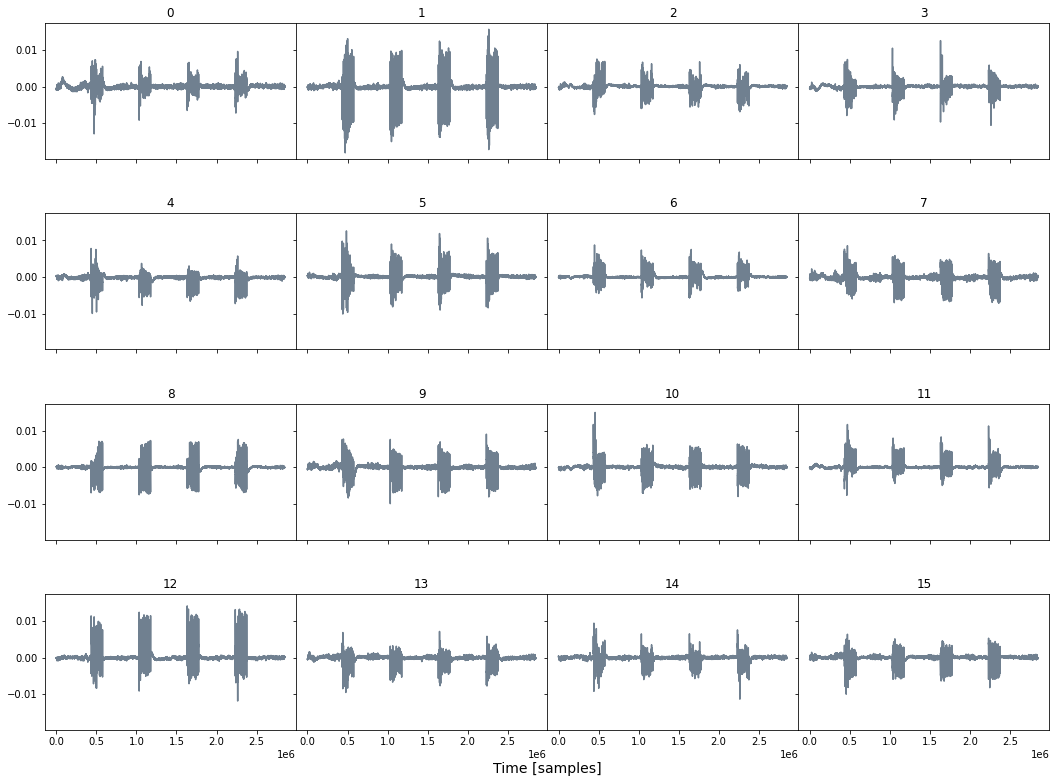

In [66]:
fig, axs = plt.subplots(4,4, figsize=(18, 13), sharex=True, sharey=True)
fig.subplots_adjust(hspace = .4, wspace=0)
axs = axs.ravel()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [samples]', fontsize=14, labelpad=15)

for i in range(16):
    axs[i].plot(comps[:, i], color='slategrey')
    axs[i].set_title(str(i))

In [69]:
# 1. Centering data
signal_MUA_magnitude_mean = np.mean(signal_MUA_magnitude, axis=0)
signal_centered = signal_MUA_magnitude - signal_MUA_magnitude_mean
signal_centered.shape

(2850301, 16)

In [70]:
# 2.Covarience matrix
cov_sig_centered = signal_centered.T.dot(signal_centered) * 1/signal_centered.shape[1]

In [72]:
cov_diag = np.eye(cov_sig_centered.shape[1])
np.fill_diagonal(cov_diag, np.sqrt(cov_sig_centered.diagonal()))

In [73]:
corr_btw_channels = np.linalg.inv(cov_diag).dot(cov_sig_centered).dot(np.linalg.inv(cov_diag))

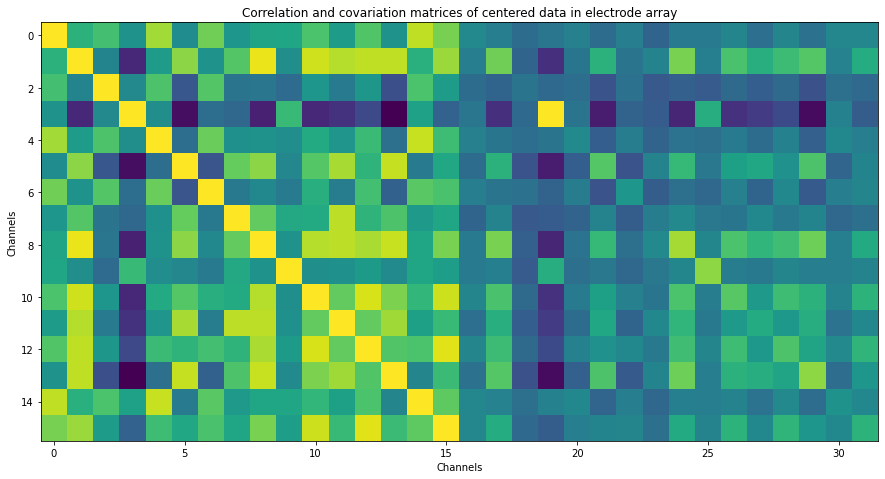

In [74]:
res = np.concatenate((corr_btw_channels, cov_sig_centered/cov_sig_centered.max()), axis=1)
corr_cov_btw_channels = plt.figure(figsize=(15,15))
ax_corr = corr_cov_btw_channels.add_subplot(1,1,1)
ax_corr.set_title('Correlation and covariation matrices of centered data in electrode array')
ax_corr.set_xlabel('Channels')
ax_corr.set_ylabel('Channels')
ax_corr.imshow(res)

In [168]:
# Eigenvalue decomposition -EVD
E_VAL, E_VEC = np.linalg.eig(cov_sig_centered)
# Same matrix factorization through SV decomposition -SVD
U, SIGMA, V = np.linalg.svd(cov_sig_centered)

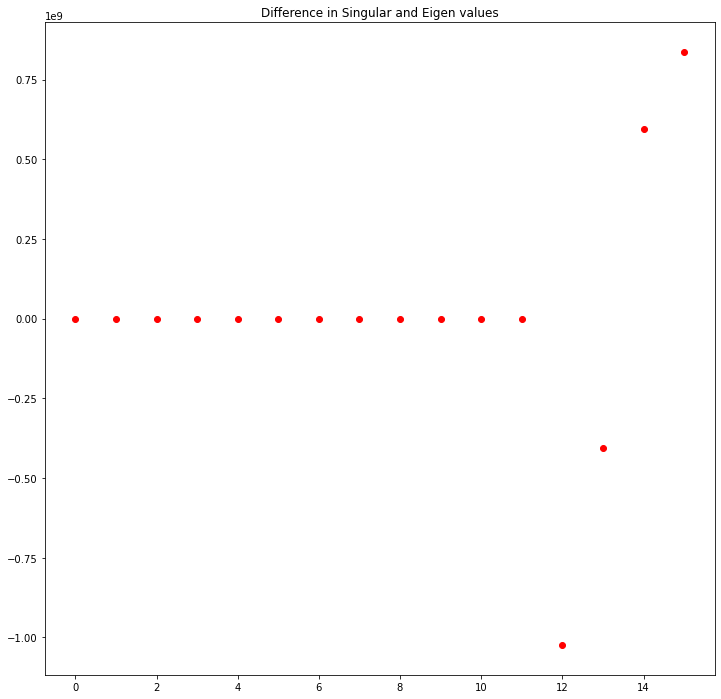

In [169]:
#Singular vs eigen values
sig_vs_eig = plt.figure(figsize=(12,12))
ax = sig_vs_eig.add_subplot(1,1,1)
ax.set_title('Difference in Singular and Eigen values')
ax.plot(E_VAL-SIGMA, 'or')
#ax.plot(E_VAL, '.k')

In [19]:
#Projecting data to orthogonal basis 
uncorr_sig_sentered = signal_centered.dot(E_VEC)

In [20]:
m_E_VAL = np.eye(E_VAL.shape[0])
np.fill_diagonal(m_E_VAL, np.sqrt(E_VAL))
whitened_sig = np.linalg.inv(m_E_VAL).dot(uncorr_sig_sentered.T)
whitened_sig.shape

(16, 2850301)

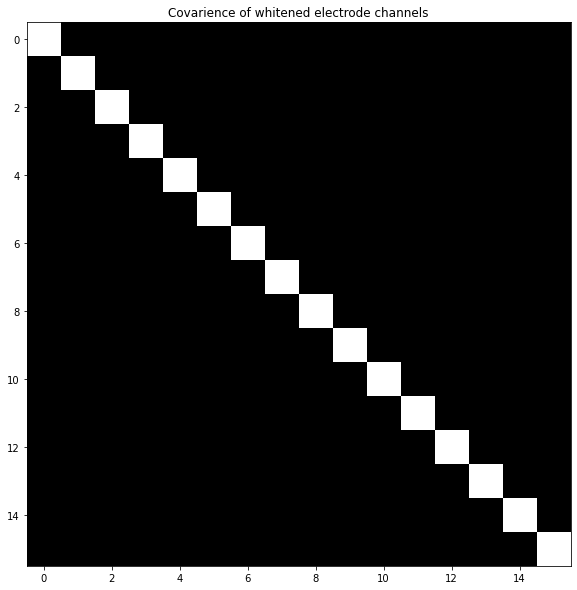

In [21]:
cov_whitened_sig = (1/16)*whitened_sig.dot(whitened_sig.T)
plt.figure(figsize=(10,10))
plt.title('Covarience of whitened electrode channels')
plt.imshow(np.round(cov_whitened_sig), cmap='Greys_r')

In [22]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=16, random_state=16, tol=0.5)
comps = ica.fit_transform(whitened_sig.T)

In [23]:
whitened_sig.shape

(16, 2850301)

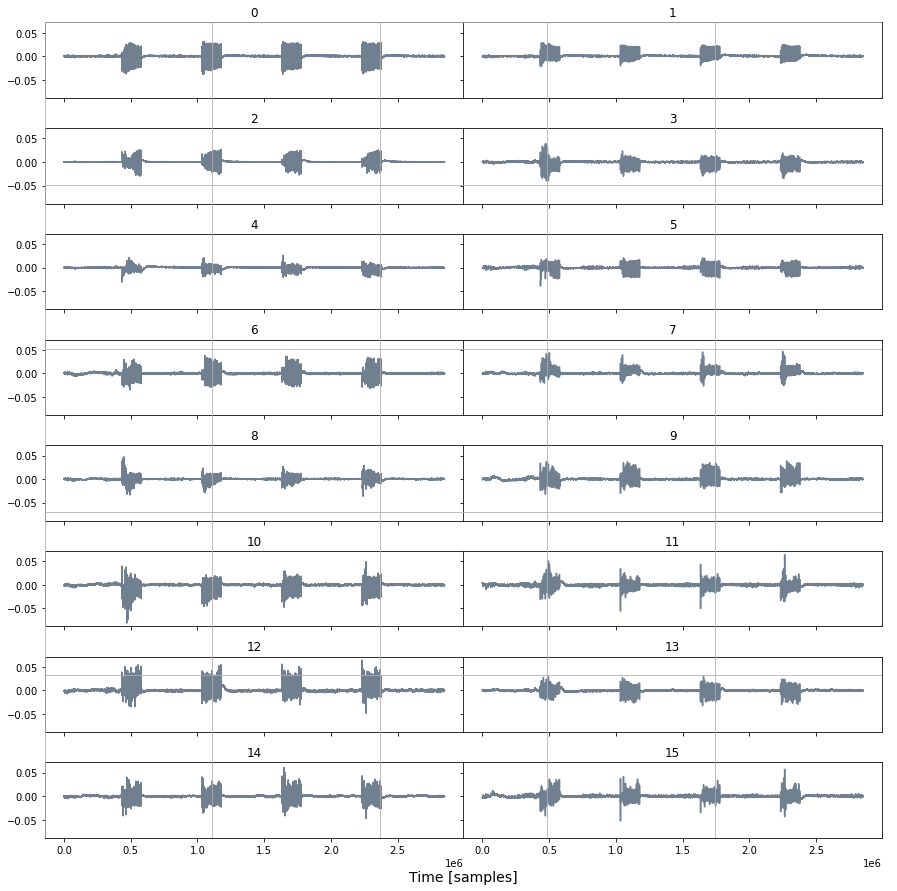

In [24]:
fig, axs = plt.subplots(8,2, figsize=(15, 15), sharex=True, sharey=True)
fig.subplots_adjust(hspace = .4, wspace=0)
axs = axs.ravel()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [samples]', fontsize=14, labelpad=15)
plt.grid()
for i in range(16):
    axs[i].plot(whitened_sig[i, :], color='slategrey')
    axs[i].set_title(str(i))

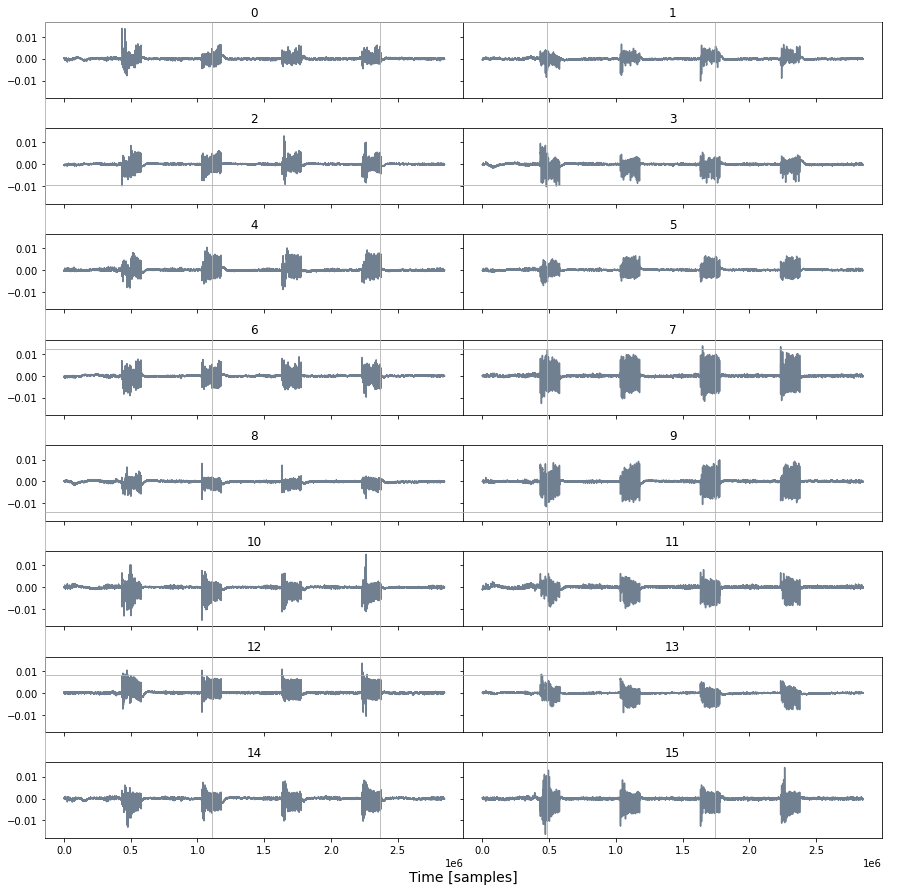

In [25]:
fig, axs = plt.subplots(8,2, figsize=(15, 15), sharex=True, sharey=True)
fig.subplots_adjust(hspace = .4, wspace=0)
axs = axs.ravel()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [samples]', fontsize=14, labelpad=15)
plt.grid()
for i in range(16):
    axs[i].plot(comps[:, i], color='slategrey')
    axs[i].set_title(str(i))

In [26]:
columns = ['electrode_' + str(i) for i in range(signal_centered.shape[1])]
raw_sig_DF = pd.DataFrame(signal_centered[::500,:], columns=columns)
white_sig_DF = pd.DataFrame(whitened_sig[:,::500].T, columns=columns)

In [27]:
import seaborn as sns
raw_sig_DF.keys()

Index(['electrode_0', 'electrode_1', 'electrode_2', 'electrode_3',
       'electrode_4', 'electrode_5', 'electrode_6', 'electrode_7',
       'electrode_8', 'electrode_9', 'electrode_10', 'electrode_11',
       'electrode_12', 'electrode_13', 'electrode_14', 'electrode_15'],
      dtype='object')

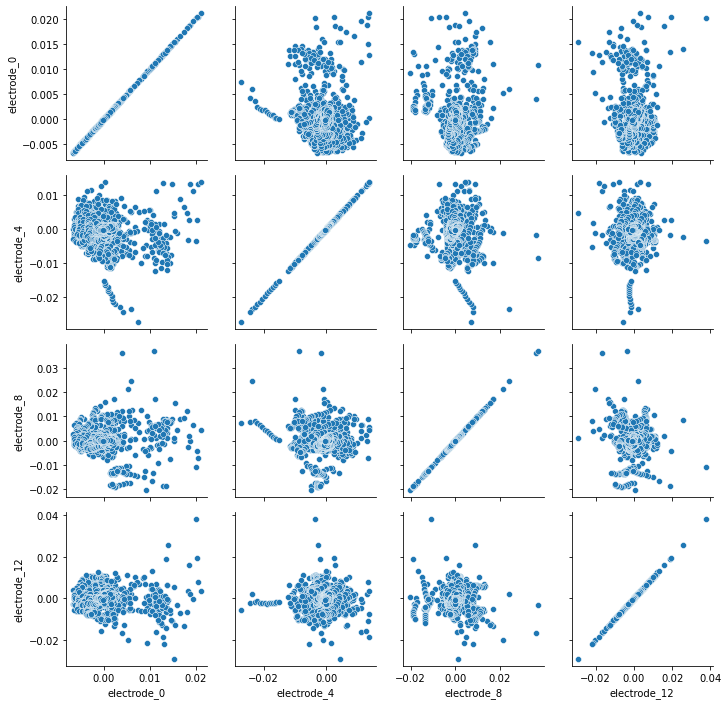

In [28]:
pal = sns.color_palette("hls", 8)
g = sns.PairGrid(white_sig_DF[columns[::4]])
g.map(sns.scatterplot)
#sns.jointplot(data=raw_sig_DF, x=columns[0], y=columns[3], kind='reg', height=10, ratio=2, marginal_ticks=True, palette="vlag")

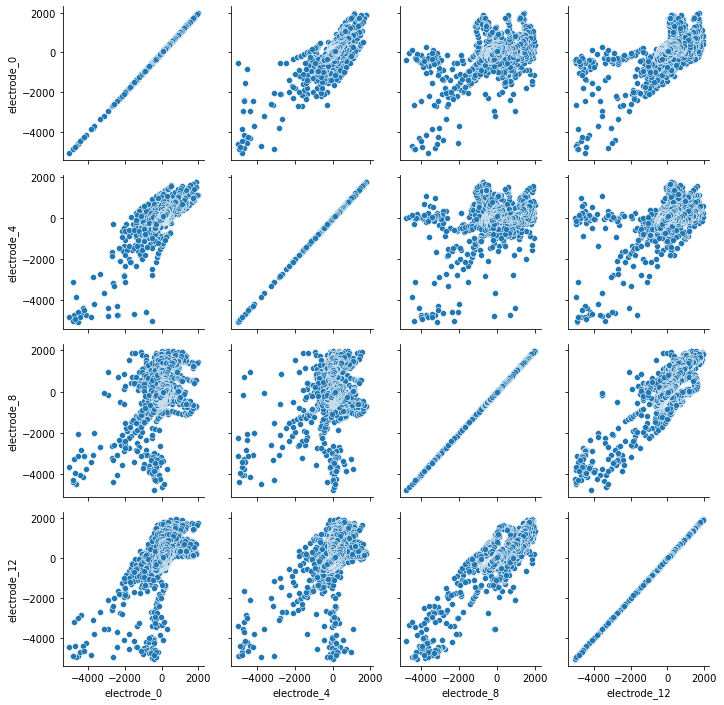

In [29]:
pal = sns.color_palette("hls", 8)
g = sns.PairGrid(raw_sig_DF[columns[::4]])
g.map(sns.scatterplot)

In [171]:
chunk = dataFrame_MUA.iloc[500000:508000]
chunk_centered = chunk - chunk.mean(axis=0)

In [197]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

chunk_centered_std = StandardScaler().fit_transform(chunk_centered)

curr_pca = PCA(n_components=16)
chunk_cent_pca = curr_pca.fit_transform(chunk_centered_std)

/home/brainy/anaconda3/envs/mua/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


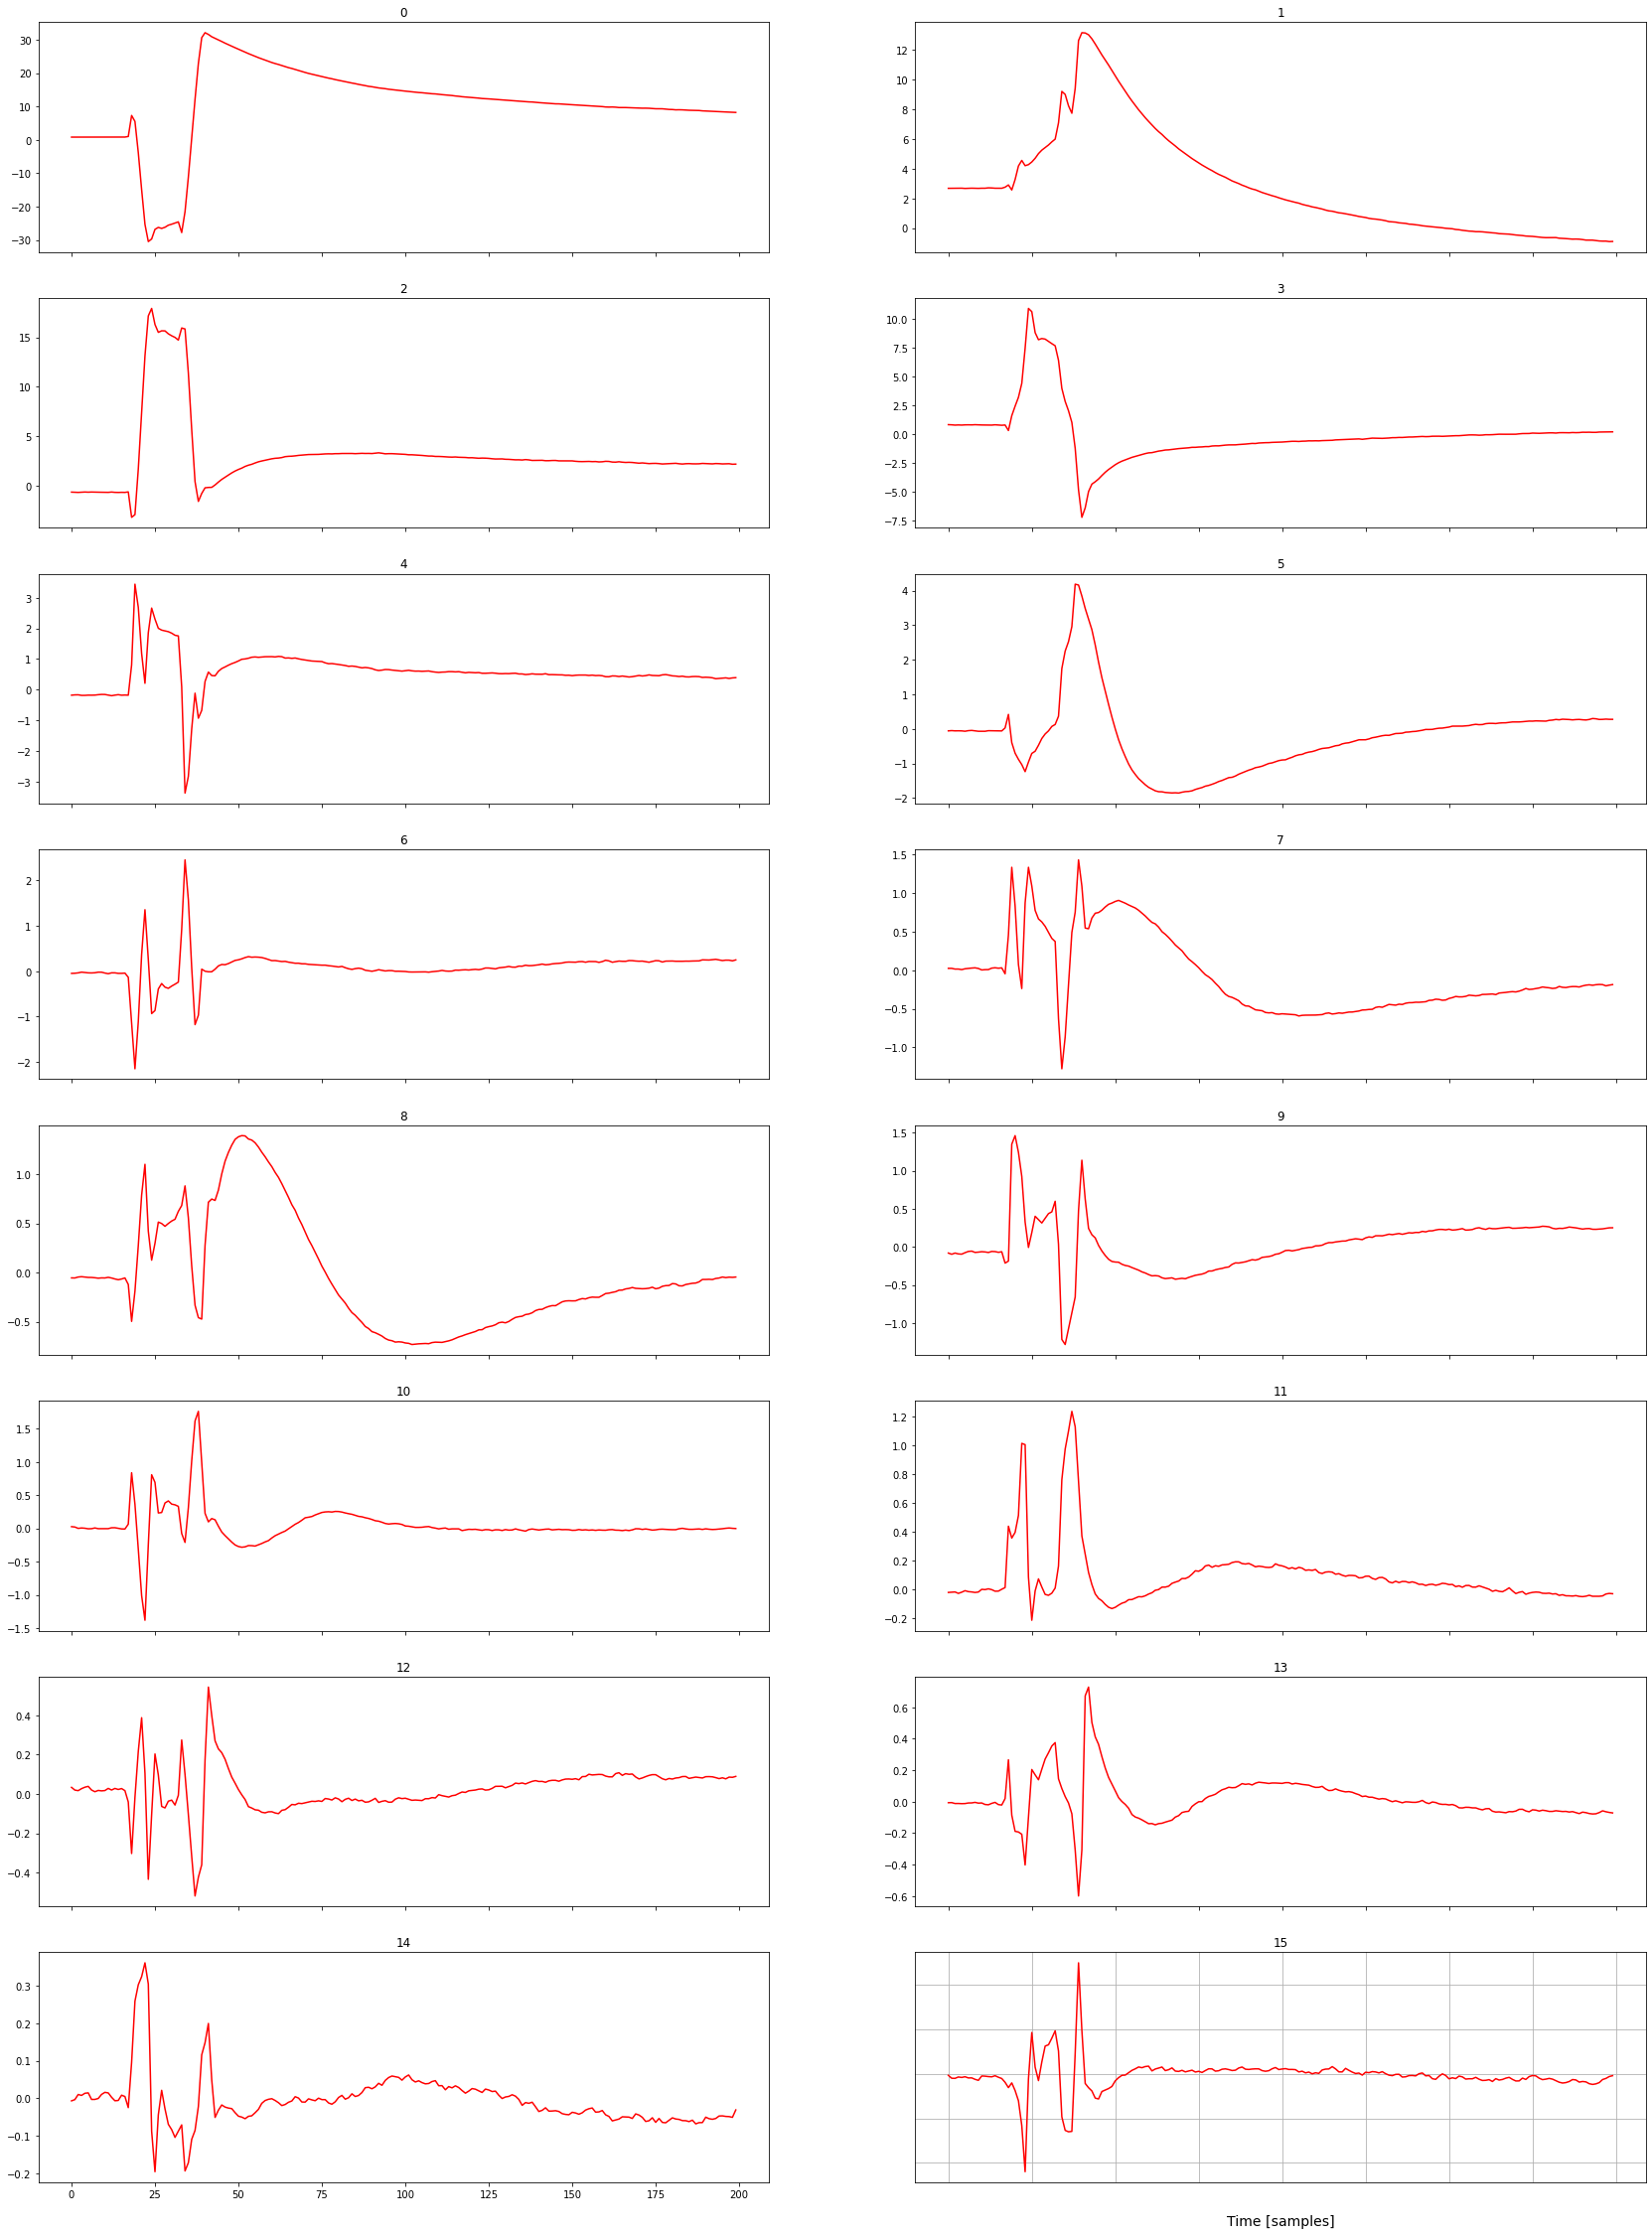

In [201]:
ig, axs = plt.subplots(8,2, figsize=(29, 40), sharex=True)
fig.subplots_adjust(hspace = .4, wspace=0)
axs = axs.ravel()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [samples]', fontsize=14, labelpad=15)
plt.grid()
for i in range(16):
    axs[i].plot(chunk_cent_pca[:, i][1400:1600], color='red')
    axs[i].set_title(str(i))

#plt.figure(figsize=(30,15))
#for i in range(chunk_cent_pca.shape[1]):
#    plt.plot(chunk_cent_pca[:,i][1400:1600])

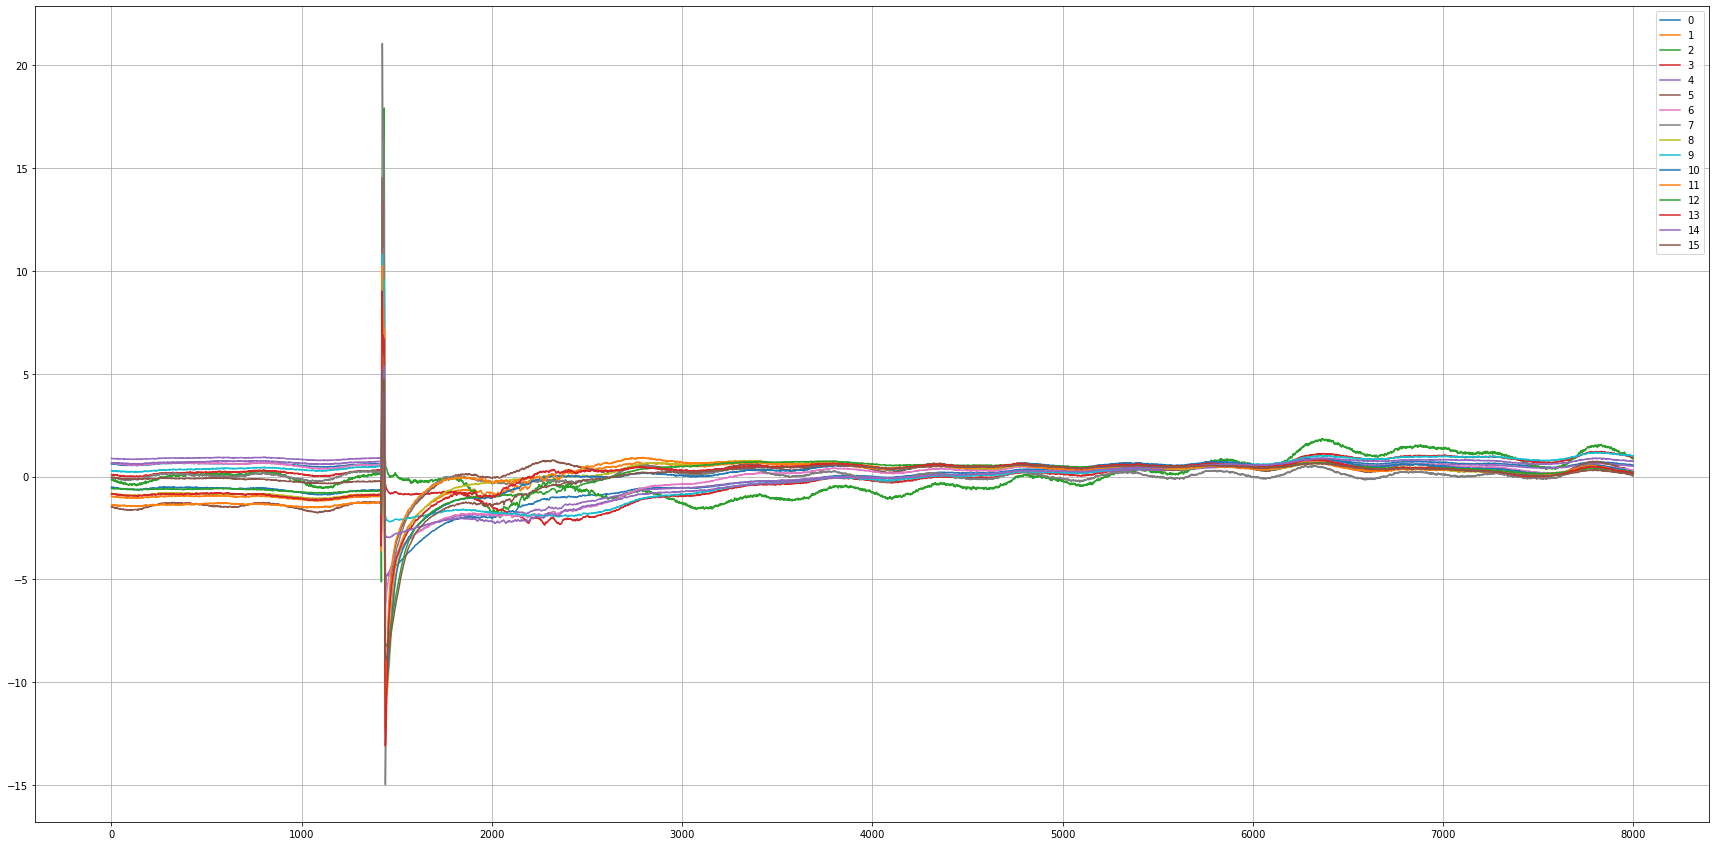

In [218]:
figure_mix = plt.figure(figsize=(30,15))
ax_mix = figure_mix.add_subplot(111)
for key in range(len(keys)):
    ax_mix.plot(chunk_centered_std[:,key], label=f'{key}')
    
plt.grid()
plt.legend()

In [116]:
new_SIGMA = np.zeros([16, 16])
new_SIGMA[0,0] = SIGMA[0]

In [120]:
first_comp = new_SIGMA.dot(V)
first_comp.shape

(16, 16)

51143.22